In [698]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal

CARGA DATOS. Cortesia de Thomas Andrade

In [699]:
def matrixCreator(raw, pixelsX, pixelsY):
    matrix = []
    for i in range(0, len(raw), pixelsX*pixelsY):
        blank = np.zeros((pixelsX, pixelsY))
        for j in range(0, pixelsX):
            for k in range(0, pixelsY):
                blank[j, k] = raw[k + pixelsX*j + i]
        matrix.append(blank) 
    return matrix

def dataCreator(filename, pixelsX, pixelsY):
    raw_array = np.fromfile(filename, dtype = "float32")
    matrix = matrixCreator(raw_array, pixelsX, pixelsY)
    return matrix

def imageCreator(data, COLValue):
    image = []
    mean = 0
    for i in range(0, COLValue + 1):
        mean += data[i]
    mean = mean/(COLValue + 1)
    image.append(mean)  
    return image[0]

In [700]:
directory = "Resultados/Wax-Alumina.raw" # String con el directorio donde se encuentra el .raw.
COL = 0 # Cambiar por el tipo de adquisición.
pixelsX = 256 
pixelsY = 256

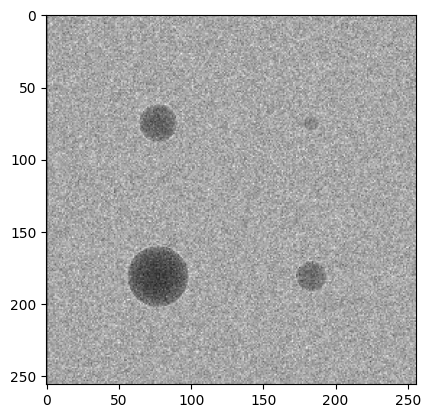

In [701]:
sample = dataCreator(directory, pixelsX, pixelsY)
image = imageCreator(sample, COL)
plt.imshow(image, cmap='gray')


FLAT FIELD FF

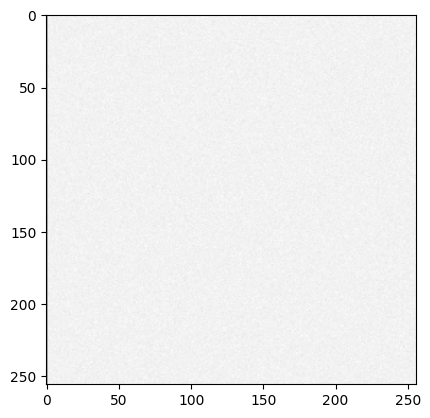

In [702]:
ffsample = dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY)
ffimage = imageCreator(ffsample, COL)
plt.imshow(ffimage, cmap='gray')

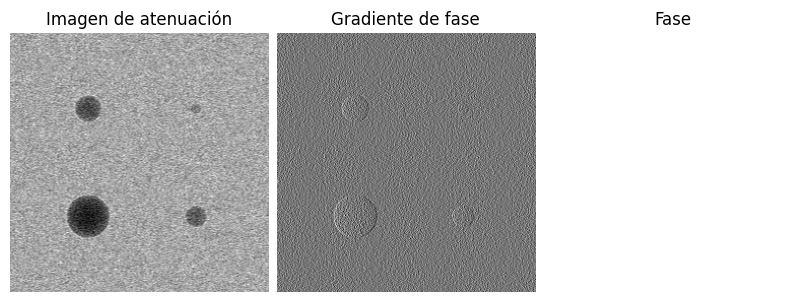

In [703]:
imagen_attenuacion=np.zeros((len(image),len(image[0])-1))
phase_grad=np.zeros((len(image),len(image[0])-1))
imagen_normalizada=image/ffimage
for i in range(0,len(image)-1):
    Nin=imagen_normalizada[:,i]
    Nim=imagen_normalizada[:,i+1]
    imagen_attenuacion[:,i]=(Nin+Nim)/2
    phase_grad[:,i]=(Nin-Nim)/(Nin+Nim)
phase_recovery=np.zeros((len(phase_grad),len(phase_grad[0])))

phase_grad=phase_grad*(79/2)*1.39


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)



ax1.imshow(imagen_attenuacion, cmap="gray")
ax1.set_title("Imagen de atenuación")
ax1.axis("off")  

ax2.imshow(phase_grad, cmap="gray")
ax2.set_title("Gradiente de fase")
ax2.axis("off")


ax3.set_title("Fase")
ax3.axis("off")

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

plt.show()



Integracion para recuperar Fase

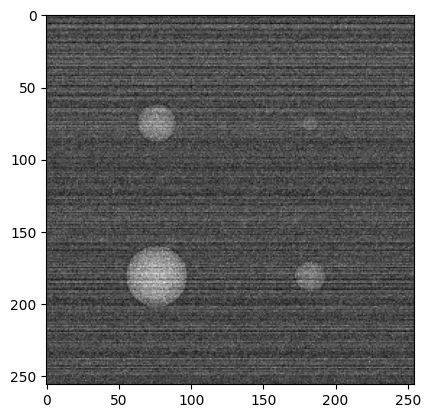

In [704]:
fase=np.zeros_like(phase_grad)
rows, cols = phase_grad.shape
dx=1
for y in range(rows):
    for x in range(1, cols):
        fase[y, x] = fase[y, x-1] + phase_grad[y, x] * dx
plt.imshow(fase, cmap='gray')

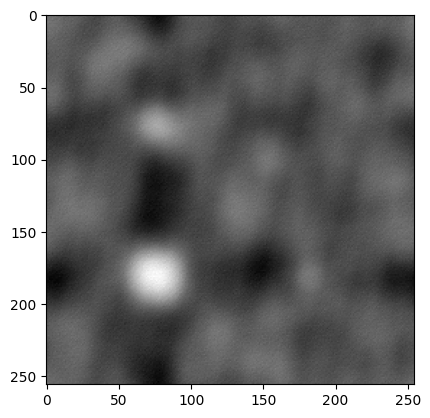

In [705]:
min_shape = np.minimum(fase.shape, ffimage.shape)
fase = fase[:min_shape[0], :min_shape[1]]
ffimage = ffimage[:min_shape[0], :min_shape[1]]
fase_fourier=np.fft.fft2(fase)
ff_fourier=np.fft.fft2(ffimage)
fase=fase_fourier*(abs(fase_fourier)**2)/(abs(fase_fourier)**2+abs(ff_fourier)**2)
fase=np.fft.ifft2(fase).real
plt.imshow(fase, cmap='gray')

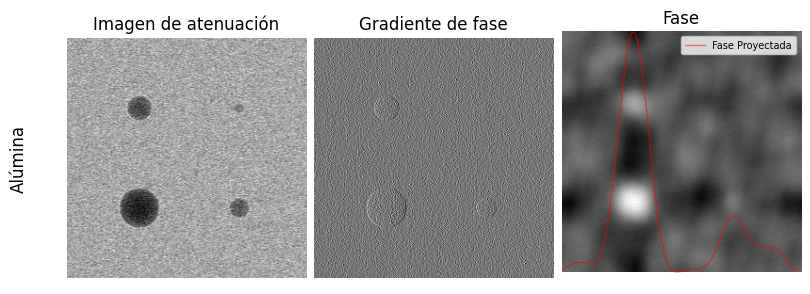

In [706]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)


ax1.text(-0.2, 0.5, "Alúmina", rotation=90,
         va='center', ha='center', fontsize=12,
         transform=ax1.transAxes)

ax1.imshow(imagen_attenuacion, cmap="gray")
ax1.set_title("Imagen de atenuación")
ax1.axis("off")  

ax2.imshow(phase_grad, cmap="gray")
ax2.set_title("Gradiente de fase")
ax2.axis("off")

ax3.imshow(fase, cmap="gray")
ax3.set_title("Fase")
ax3.axis("off")

promedio_columna = np.mean(fase, axis=0)
promedio_normalizado = (promedio_columna - np.min(promedio_columna))
promedio_normalizado /= np.max(promedio_normalizado)  
promedio_normalizado *= fase.shape[0]  

ax3.plot(
    np.arange(fase.shape[1]),
    fase.shape[0] - promedio_normalizado,
    color='r', linewidth=1, alpha=0.5, label="Fase Proyectada"
)
ax3.legend(fontsize=7)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

plt.show()


Para Todos los Materiales

In [707]:
def process_image(image,ffimage):
    imagen_attenuacion=np.zeros((len(image),len(image[0])-1))
    phase_grad=np.zeros((len(image),len(image[0])-1))
    imagen_normalizada=image/ffimage
    for i in range(0,len(image)-1):
        Nin=imagen_normalizada[:,i]
        Nim=imagen_normalizada[:,i+1]
        imagen_attenuacion[:,i]=(Nin+Nim)/2
        phase_grad[:,i]=(Nin-Nim)/(Nin+Nim)
    phase_grad=phase_grad*(79/2)*1.39
    fase=np.zeros_like(phase_grad)
    rows, cols = phase_grad.shape
    dx=1
    for y in range(rows):
        for x in range(1, cols):
            fase[y, x] = fase[y, x-1] + phase_grad[y, x] * dx
    min_shape = np.minimum(fase.shape, ffimage.shape)
    fase = fase[:min_shape[0], :min_shape[1]]
    ffimage = ffimage[:min_shape[0], :min_shape[1]]
    fase_fourier=np.fft.fft2(fase)
    ff_fourier=np.fft.fft2(ffimage)
    fase=fase_fourier*(abs(fase_fourier)**2)/(abs(fase_fourier)**2+abs(ff_fourier)**2)
    fase=np.fft.ifft2(fase).real
    plt.imshow(fase, cmap='gray')
    return imagen_attenuacion, phase_grad, fase

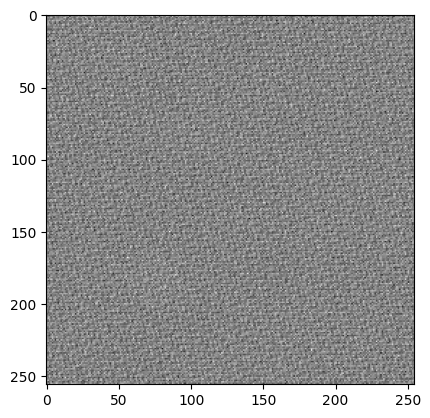

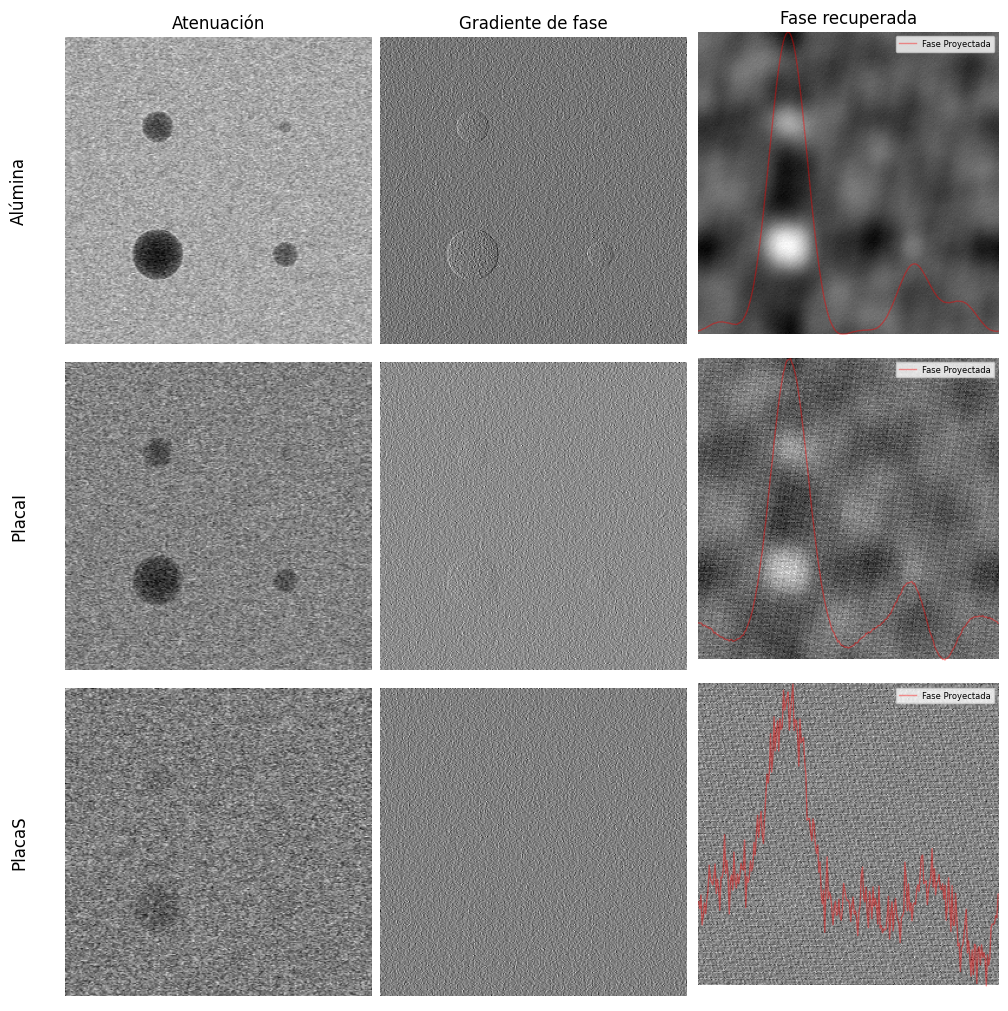

In [ ]:

# Material 1: Wax–Alúmina
imagen_att_WA   = process_image(imageCreator(dataCreator("Resultados/Wax-Alumina.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[0]
grad_fase_WA    = process_image(imageCreator(dataCreator("Resultados/Wax-Alumina.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[1]
fase_WA         = process_image(imageCreator(dataCreator("Resultados/Wax-Alumina.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[2]

# Material 2: Wax–PlacaI
imagen_att_WP_I = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaI.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[0]
grad_fase_WP_I  = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaI.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[1]
fase_WP_I       = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaI.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[2]

# Material 3: Wax–PlacaS
imagen_att_WP_S = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaS.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[0]
grad_fase_WP_S  = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaS.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[1]
fase_WP_S       = process_image(imageCreator(dataCreator("Resultados/Wax-PlacaS.raw", pixelsX, pixelsY),0),
                                imageCreator(dataCreator("Resultados/Flat_Field.raw", pixelsX, pixelsY),0))[2]



def add_phase_projection(ax, fase):
    prom = np.mean(fase, axis=0)
    prom = (prom - np.min(prom))
    prom /= np.max(prom)
    prom *= fase.shape[0]

    ax.plot(
        np.arange(fase.shape[1]),
        fase.shape[0] - prom,
        color='r', linewidth=1, alpha=0.4,
        label="Fase Proyectada"
    )
    ax.legend(fontsize=6)


fig, axes = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

materiales = [
    ("Alúmina", imagen_att_WA,   grad_fase_WA,   fase_WA),
    ("PlacaI",  imagen_att_WP_I, grad_fase_WP_I, fase_WP_I),
    ("PlacaS",  imagen_att_WP_S, grad_fase_WP_S, fase_WP_S),
]

titulos_columnas = ["Atenuación", "Gradiente de fase", "Fase recuperada"]

for i, (nombre, att, grad, fase) in enumerate(materiales):

    axes[i, 0].text(
        -0.15, 0.5, nombre, rotation=90,
        va='center', ha='center', fontsize=12,
        transform=axes[i, 0].transAxes
    )


    axes[i, 0].imshow(att, cmap="gray")
    if i == 0:  # títulos SOLO arriba
        axes[i, 0].set_title(titulos_columnas[0])
    axes[i, 0].axis("off")


    axes[i, 1].imshow(grad, cmap="gray")
    if i == 0:
        axes[i, 1].set_title(titulos_columnas[1])
    axes[i, 1].axis("off")


    axes[i, 2].imshow(fase, cmap="gray")
    if i == 0:
        axes[i, 2].set_title(titulos_columnas[2])
    axes[i, 2].axis("off")


    add_phase_projection(axes[i, 2], fase)

    for j in range(3):
        axes[i, j].set_aspect('equal')

plt.savefig("Imagenes_Materiales.png")
